In [1]:
import os
import sys
from functools import partial

import ase
import numpy as np
from ase.io import read, write
from matplotlib import pyplot as plt
import matplotlib as mpl
from openTSNE import TSNE
from rascal.representations import SphericalInvariants as SOAP
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import normalize
import sklearn.cluster as cluster
import seaborn as sns
from tqdm.auto import tqdm
import hdbscan

from utils import set_mpl_fonts, set_cmap

set_mpl_fonts()
cmap = set_cmap()

## Prepare Data

In [2]:
# total number of frames to consider
n_total = 10000

In [3]:
# read in the full simulation trajectory
traj = read('./cyclohexane_data/MD/trajectory.xyz', '1:')
n_skip = len(traj) // n_total
traj = traj[::n_skip]

# read in the frames corresponding to these conformers
names = ['chair', 'twist-boat', 'boat', 'half-chair', 'planar']
conf_traj = [read(f'./cyclohexane_data/conformers/{n}.xyz') for n in names]

for frame in [*traj, *conf_traj]:

    # wrap each frame in its box
    frame.wrap(eps=1E-10)

    # mask each frame so that descriptors are only centered on carbon (#6) atoms
    mask = np.zeros(len(frame))
    mask[np.where(frame.numbers == 6)[0]] = 1
    frame.arrays['center_atoms_mask'] = mask


print(len(traj))

11458


In [4]:
# energies of the simulation frames
energy = np.array([a.info['energy_eV'] for a in traj])

# energies of the known conformers
c_energy = np.array([frame.info['energy_eV'] for frame in conf_traj])

In [5]:
# extrema for the energies
max_e = max(c_energy)
min_e = min(c_energy)

### SOAP descriptors 

In [53]:
# computed in `Dimensionality_Reduction_Cyclohexanes.ipynb`
data = np.load('./cyclohexane_data/soap_vectors.npz')
mean_soaps = data['mean_soaps'][:: n_skip]
conf_mean_soaps = data['conf_mean_soaps']

mean_soaps.shape, conf_mean_soaps.shape

((11458, 1080), (5, 1080))

### Load Embeddings

In [43]:
# computed in `Dimensionality_Reduction_Cyclohexanes.ipynb`
pca_data = np.load('cyclohexane_data/pca.npz')
t_pca = pca_data['pca'][::n_skip]
t_pca_conf = pca_data['pca_conf']

tsne_data = np.load('cyclohexane_data/tsne.npz')
t_tsne = tsne_data['tsne'][::n_skip]
t_tsne_conf = tsne_data['tsne_conf']

lle_data = np.load('cyclohexane_data/lle.npz')
t_lle = lle_data['lle'][::n_skip]
t_lle_conf = lle_data['lle_conf']

umap_data = np.load('cyclohexane_data/umap.npz')
t_umap = umap_data['umap'][::n_skip]
t_umap_conf = umap_data['umap_conf']

pcovr_data = np.load('cyclohexane_data/pcovr.npz')
t_pcovr = pcovr_data['pcovr'][::n_skip]
t_pcovr_conf = pcovr_data['pcovr_conf']

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, rep, rep_name in zip(axes, [t_pca, t_tsne, t_lle, t_umap, t_pcovr],
                             ['PCA', 't-SNE', 'LLE', 'UMAP', "PCovR"]):

    ax.scatter(
        rep[:, 0],
        rep[:, 1],
        s=1,
        c=energy,
        cmap=cmap,
    )

    ax.set_title(rep_name, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(top=0.8)
plt.suptitle('Mappings from `Dimensionality_Reduction_Cyclohexanes.ipynb`')
plt.show()

## Clustering

In [97]:
def plot_clusters(
    clustering_algorithm,
    clustering_algorithm_name='',
    reps=[mean_soaps, t_pca, t_tsne, t_lle, t_umap, t_pcovr],
    rep_names=[
        'SOAP Vectors\n(Plotted along PC1&2)', 'PCA', 't-SNE', 'LLE', 'UMAP',
        "PCovR"
    ],
    **kwds,
):
    all_labels = []

    if len(reps) > 1:
        fig, axes = plt.subplots(1, len(reps), figsize=(len(reps) * 3, 3))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 8))
        axes = [axes]

    for ax, rep, rep_name in zip(axes, reps, rep_names):
        alg = clustering_algorithm(**kwds)
        labels = alg.fit_predict(rep)
        all_labels.append(labels)
        np.maximum(labels, 0)

        nclusters = len(np.unique(labels))

        if nclusters < 256:
            if nclusters < 10:
                cmap = plt.get_cmap('tab10')
            elif nclusters < 20:
                cmap = plt.get_cmap('tab20')
            else:
                cmap = plt.get_cmap('magma')
            norm = mpl.colors.BoundaryNorm(np.arange(-0.5, nclusters + 0.5),
                                           cmap.N)
        else:
            cmap = plt.get_cmap('magma')
            norm = mpl.colors.BoundaryNorm(np.arange(0, 256), cmap.N)

        ax.scatter(
            rep[:, 0] if 'SOAP' not in rep_name else t_pca[:, 0],
            rep[:, 1] if 'SOAP' not in rep_name else t_pca[:, 1],
            s=2,
            c=labels,
            cmap=cmap,
            norm=norm,
            alpha=0.5,
        )

        plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                     ax=ax,
                     orientation='horizontal',
                     ticks=range(0, nclusters)[::max(1,nclusters//20)])

        ax.set_title(rep_name, fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        

    fig.subplots_adjust(top=0.8)
    plt.suptitle(clustering_algorithm_name)
    return all_labels

### K-Means on all Embeddings

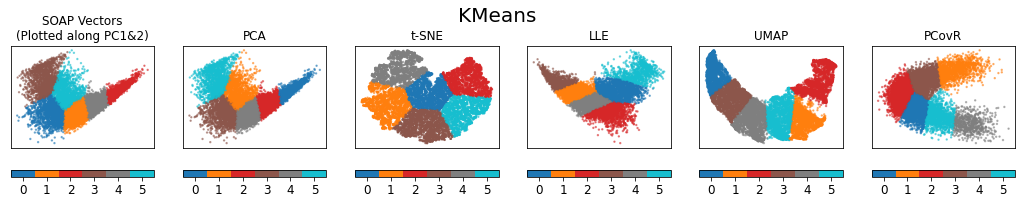

In [104]:
_, km_labels, _, _, _, _ = plot_clusters(cluster.KMeans, 'KMeans', **dict(n_clusters=6))

### Comparing Clusterings of the PCA Embedding

From here on, we'll just work with the PCA map, but you can swap it out to see other results!

For the sake of demonstration, we will also assume that a "ground truth" clustering via Agglomerative Clustering of the soap vectors into 6 regimes.

In [70]:
from scipy.spatial.distance import cdist

In [92]:
dist = cdist(t_pca[:, :2], t_pca_conf[:, :2])
truth_labels = dist.argmin(axis=1)

In [93]:
# alg = cluster.KMeans(n_clusters=5, init=conf_mean_soaps, n_init=1, max_iter=1)
# truth_labels = alg.fit_predict(mean_soaps)

(array([   0.,    0.,    0.,    0.,  451.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0., 8430.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 1488.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 1074.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   15.,
           0.,    0.,    0.,    0.]),
 array([-0.5       , -0.39795918, -0.29591837, -0.19387755, -0.09183673,
         0.01020408,  0.1122449 ,  0.21428571,  0.31632653,  0.41836735,
         0.52040816,  0.62244898,  0.7244898 ,  0.82653061,  0.92857143,
         1.03061224,  1.13265306,  1.23469388,  1.33673469,  1.43877551,
         1.54081633,  1.64285714,  1.74489796,  1.84693878,  1.94897959,
         2.05102041,  2.15306122,  2.25510204,  2.35714286,  2.45918367,
         2.56122449,  2.66326531,  2.76530612,  2.86734694,  2.96938776,
         3.07142857,  3.17346939,  3.2755102 ,  3.37755102,  3.47959184,
         3.58163265,  3

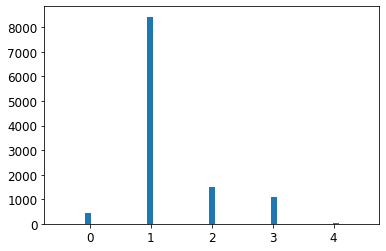

In [94]:
plt.hist(truth_labels, bins=np.linspace(-0.5,4.5))

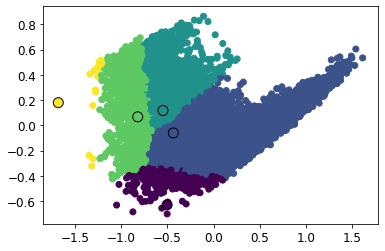

In [95]:
plt.scatter(*t_pca[:, :2].T, c=truth_labels, vmax=4, vmin=0)
plt.scatter(*t_pca_conf[:, :2].T, c=range(5), s=100, ec='k')

In [ ]:
truth_labels = cluster.AgglomerativeClustering(n_clusters=6).fit_predict(mean_soaps)

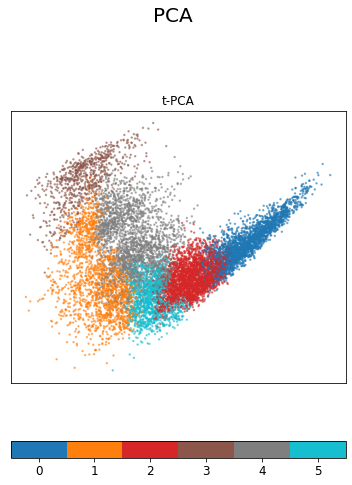

In [98]:
ac_labels = plot_clusters(cluster.AgglomerativeClustering,
              'PCA',
              **dict(n_clusters=6),
              reps=[t_pca],
              rep_names=['t-PCA'])

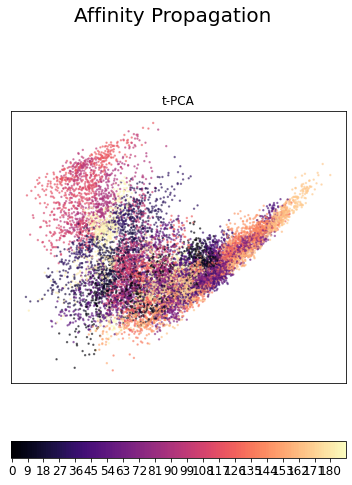

In [99]:
ap_labels = plot_clusters(cluster.AffinityPropagation,
              'Affinity Propagation',
              **dict(),
              reps=[t_pca],
              rep_names=['t-PCA'])

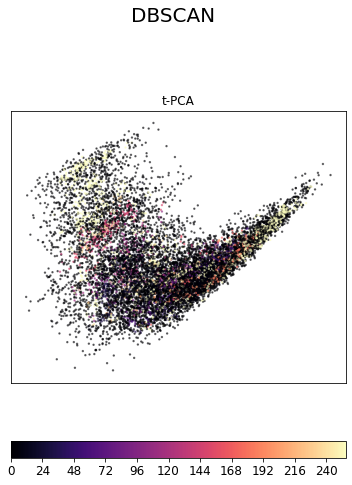

In [100]:
db_labels = plot_clusters(cluster.DBSCAN,
              'DBSCAN',
              **dict(eps=0.09, min_samples=3),
              reps=[t_pca],
              rep_names=['t-PCA'])

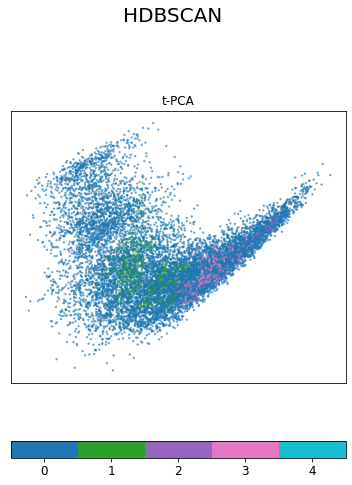

In [101]:
hdb_labels = plot_clusters(hdbscan.HDBSCAN,
              'HDBSCAN',
              **dict(min_cluster_size=100, min_samples=2),
              reps=[t_pca],
              rep_names=['t-PCA'])

In [102]:
from sklearn.metrics import (davies_bouldin_score, silhouette_score,
                             rand_score, fowlkes_mallows_score, jaccard_score,
                             f1_score)
scorings = (davies_bouldin_score, silhouette_score,
                             rand_score, fowlkes_mallows_score, jaccard_score,
                             f1_score)
import pandas as pd

In [105]:
scores = np.array([[
    davies_bouldin_score(mean_soaps,
                         np.array(labels).flatten()),
    silhouette_score(mean_soaps,
                     np.array(labels).flatten()),
    rand_score(truth_labels,
               np.array(labels).flatten()),
    fowlkes_mallows_score(truth_labels,
                          np.array(labels).flatten()),
    jaccard_score(truth_labels, np.array(labels).flatten(), average='macro'),
    f1_score(truth_labels, np.array(labels).flatten(), average='macro'),
] for labels in [km_labels, ac_labels, ap_labels, db_labels, hdb_labels]])

In [106]:
df = pd.DataFrame(scores,
                  columns=["DB", "Silhouette", "Rand", "FM", "Jaccard", "F"],
                  index=[
                      'K-Means', 'Agglomerative Clustering',
                      'Affinity Propagation', 'DBScan', 'HDBScan'
                  ])
df.style.format(precision=2)

,DB,Silhouette,Rand,FM,Jaccard,F
K-Means,1.14,0.26,0.53,0.44,0.04,0.08
Agglomerative Clustering,1.29,0.20,0.53,0.44,0.06,0.10
Affinity Propagation,1.59,0.11,0.44,0.09,0.00,0.00
DBScan,1.61,-0.54,0.46,0.47,0.00,0.00
HDBScan,2.33,-0.39,0.50,0.63,0.01,0.03


From here, we can see that K-Means and Agglomerative Clustering best capture the shape of the data (seen by the low Davies-Bouldin and high silhouette scores). This is further supported by external metrics compared against our our "ground truth" clustering, with high Rand, Fowlkes-Mallows, Jaccard, and F-scores. 

This may, in part, be due to the parameterization of DBScan and HDBScan, but is more likely due to the nature of the algorithms. In K-Means and Agglomerative Clustering, we _set_ the number of clusters desired, and the variety of our result is heavily restricted. In DBScan and HDBScan, we are basing our clustering off of local parameters and distances, with an unrestricted result space.